## Graph RAG

Графовый RAG основан на извлечении графа знаний из текста и его использовании для улучшения качества ответов на вопросы.

В качестве предметной области возьмём [винную энциклопедию](https://food.ru/encyclopedia/wines), а именно информацию о сортах винограда и регионах.

Для экспериментов возьмём небольшой текст из этой энциклопедии:

In [1]:
import os
from yandex_chain import YandexLLM, YandexGPTModel
llm = YandexLLM(folder_id=os.environ['folder_id'],
                api_key=os.environ['api_key'],
                model=YandexGPTModel.Pro)

text = """
Каберне фран
«Каберне́ фра́н» — темный сорт винограда, один из древнейших мировых сортов, от которого произошли такие сорта как: «каберне совиньон», «карменер», мерло». «Фран» в названии обозначает «французский». Происхождение слова «каберне» имеет разные версии, однако подлинность их не установлена. Используется для производства красных и розовых вин, как моносортовых, так и в составе бленда из нескольких сортов.
Некоторые исследования указывают на то, что предок сорта «каберне фран» завезен во Францию из Испании. Существуют отдельные указания на то, что «каберне фран» выращивали на виноградниках долины Луары еще в XIV веке. Однако чаще можно встретить версию, что этот сорт начали активно и повсеместно высаживать во Франции в XVII веке.
«Каберне фран» часто используют для создания ассамбляжа красных вин. Процент этого сорта в составе бленда с «мерло» и «каберне совиньон» может быть как минимальным, так и достигать 50% от общего объема.
Красные вина каберне фран отличаются характерным ароматом, в котором присутствуют травяные оттенки, особенно аромат зеленого перца, пряные и табачные ноты. Вкус, в зависимости от региона производства, может варьироваться от сладких ягодных оттенков малины, ежевики до пикантных нот лаврового листа, табака, графита или гравия.
Розовые вина из «каберне фран» могут впечатлять и нежными ягодными оттенками, и выразительным ароматом свежей выпечки.
Моносортовые вина из «каберне фран» могут стать отличным сопровождением множеству простых и сложных блюд. Более легкие вина составят хорошую компанию рыбе и белым сортам мяса. Яркие и выразительные каберне фран можно подавать с самым разным мясом: птицей, говядиной, свининой, сопровождая гарниром из овощей, например, спаржей. Необычные соусы и пикантные приправы также могут подчеркнуть и дополнить вкус вина.
Каберне фран может сопровождать выпечку с начинками из мяса, равиоли и разнообразные пасты.
"""

Для извлечения графа знаний будем использовать YandexGPT Pro. При этом потребуется написать достаточно сложный запрос, который позволит извлечь из текста все сущности и связи. При написании промпта мы вдохновлялись реализацией [Microsoft GraphRAG](https://github.com/microsoft/graphrag), а именно брали за основу промты [отсюда](https://github.com/microsoft/graphrag/blob/main/graphrag/prompt_tune/prompt/entity_relationship.py).

In [2]:
entity_extraction_prompt = """
# Цель
Тебе на вход даётся текстовый документ. Сначала выдели все сущности, которые необходимы, чтобы передать всю содержащуются в тексте информацию и идеи. Далее, найди все связи между этими сущностями в тексте. 

# Шаги
1. Выдели все сущности. Для каждой найденной сущности, укажи:
- entity_name: Имя сущности, заглавными буквами
- entity_type: Предложи несколько категорий для сущности. Категории не должны быть конкретными, а должны быть наиболее общими. 
- entity_description: Подробное описание атрибутов сущности.
Не используй кавычки и другие знаки препинания в имени сущности. Удаляй лишние кавычки.
Выведи информацию о сущности в следующем виде (entity|<entity_name>|<entity_type>|<entity_description>)

2. Для всех сущностей, выделенных на шаге 1, выдели все связи, т.е. пары (исходная_сущность, целевая_сущность) которые *связаны* между собой.
Для каждой пары связанных сущностей, извлеки следующую информацию:
- source_entity: имя исходной сущности, как она найдена на шаге 1
- target_entity: имя целевой сущности, как она найдена на шаге 1
- relationship_name: короткое имя связи между сущностями
- relationship_description: описание того, как исходная сущность и целевая сущность связаны между собой. В связах могут участвовать только сущности, выделенные на шаге 1. 
 Выведи информацию о связях в следующем виде (relationship|<source_entity>|<target_entity>|<relationship_name>|<relationship_description>)

3. Выведи результат в виде списка, содержащего все сущности, найденные на шаге 1, и связи, найденные на шаге 2. Используй **перевод строки** как разделитель списка.

4. Когда закончишь, выведи [EOF]

######################
-Примеры-
######################
Текст:
Борщ — горячий заправочный суп на основе свёклы, которая придаёт ему характерный красный цвет.
В словаре В. И. Даля — род щей, похлёбка из квашеной свёклы, на говядине и свинине, или со свиным салом. Получило широкое распространение во многих национальных кухнях: это блюдо есть у русских, белорусов и др.
######################
Результат:
(entity|БОРЩ|БЛЮДО|горячий заправочный суп на основе свёклы)
(entity|ГОВЯДИНА|ИНГРЕДИЕНТ|Мясо коровы, входящее в состав борща)
(entity|СВИНИНА|ИНГРЕДИЕНТ|Мясо свиньи, входящее в состав борща)
(entity|ЩИ|БЛЮДО|вид первого блюда)
(entity|РУССКИЕ|НАРОД|проживающие в России)
(entity|БЕЛОРУСЫ|НАРОД|проживающие в Белоруссии)
(relationship|БОРЩ|ЩИ|ЧАСТНЫЙ_СЛУЧАЙ|Борщ является разновидностью Щей)
(relationship|БОРЩ|ГОВЯДИНА|СОДЕРЖИТ|Борщ может содержать говядину)
(relationship|БОРЩ|СВИНИНА|СОДЕРЖИТ|Борщ может содержать свинину)
(relationship|БОРЩ|РУССКИЕ|РАСПРОСТРАНЕНИЕ|Борщ распространён у русских)
(relationship|БОРЩ|БЕЛОРУСЫ|РАСПРОСТРАНЕНИЕ|Борщ распространён у белорусов)
[EOF]
######################
Текст:
Цифровой рубль  — цифровая валюта центрального банка, разрабатываемая Банком России (ЦБ РФ), третья форма российской национальной валюты в дополнение к уже существующим наличной и безналичной формам денег.
Цифровой рубль будет эмитироваться Банком России. Цифровой рубль сочетает в себе свойства наличных и безналичных рублей.
######################
Результат:
(entity|ЦИФРОВОЙ_РУБЛЬ|ВАЛЮТА|цифровая валюта центрального банка)
(entity|БАНК РОССИИ|БАНК|Центральный банк России)
(entity|НАЛИЧНАЯ|ФОРМА ДЕНЕГ|Деньги, распространяемые купюрами)
(entity|БЕЗНАЛИЧНАЯ|ФОРМА ДЕНЕГ|Деньги, распространяемые в электронном виде)
(relationship|ЦИФРОВОЙ РУБЛЬ|БАНК РОССИИ|ЭМИТИРУЕТСЯ|Цифровой рубль будет эмитироваться Банком России)
(relationship|ЦИФРОВОЙ РУБЛЬ|НАЛИЧНАЯ|ИМЕЕТ_СВОЙСТВА|Цифровой рубль имеет свойста наличных денег)
(relationship|ЦИФРОВОЙ РУБЛЬ|БЕЗНАЛИЧНАЯ|ИМЕЕТ_СВОЙСТВА|Цифровой рубль имеет свойста безналичных денег)
######################
-Реальные данные-
######################
Текст: {}
######################
Результат:
"""

res = llm.invoke(entity_extraction_prompt.format(text))
print(res)

(entity|Каберне фран|сорт винограда|тёмный сорт винограда)
(entity|Франция|страна|Страна, куда привезли предок сорта «каберне фран»)
(entity|Испания|страна|Возможная страна, откуда во Францию завезли предок «каберне фран» )
(entity|Долина Луары|регион|Регион Франции, где могли выращивать «каберне фран» в XIV веке)
(relationship|Каберне фран|Франция|Происхождение|Предок сорта «каберне фран» завезен во Францию)
(entity|Красные вина|тип вин|Вина, для создания которых часто используют сорт «каберне фран»)
(entity|Розовые вина|тип вин|Тип вин, который также можно создать из сорта «каберне фран»)
(relationship|Красные вина|Каберне фран|ИСПОЛЬЗУЕТСЯ ДЛЯ СОЗДАНИЯ|Сорт «каберне фран» используется для создания красных вин)
(relationship|Розовые вина|Каберне фран|ИСПОЛЬЗУЕТСЯ ДЛЯ СОЗДАНИЯ|Сорт «каберне фран» также используют для создания розовых вин)
(relationship|Ассамбляж|Красные вина|ТИП|Красные вина — это тип вин, которые являются ассамбляжем)
(relationship|Сложные блюда|красные вина|СОПРОВОЖ

Возьмём информацию о регионах и сортах винограда:

In [3]:
from tqdm.auto import tqdm

with open('../source/wines.txt',encoding='utf-8') as f:
    wines = ''.join(f.readlines())
with open('../source/regions.txt',encoding='utf-8') as f:
    regions = ''.join(f.readlines())

wines = wines.split('-----')
regions = regions.split('-----')

Теперь прогоним всю нашу текстовую базу знаний через LLM-модель и запишем результаты в файлы. 

**ВНИМАНИЕ**: Эта процедура занимает много времени, поэтому если вы хотите просто посмотреть, как это работает - вы можете пропустить её, поскольку результирующие файлы уже находятся в директории `raw`.

In [ ]:
with open('raw/er.txt','w',encoding='utf-8') as f:
    for x in tqdm(wines):
        res = llm.invoke(entity_extraction_prompt.format(x))
        f.write(res)
    

In [61]:
with open('raw/er-reg.txt','w',encoding='utf-8') as f:
    for x in tqdm(regions):
        res = llm.invoke(entity_extraction_prompt.format(x))
        f.write(res)
    

100%|██████████| 205/205 [58:38<00:00, 17.17s/it] 


Поскольку в тексте использовались символы с ударениями, мы напишем функцию для их удаления:

In [5]:
import unicodedata

ACCENT_MAPPING = {
    '́': '',
    '̀': '',
    'а́': 'а',
    'а̀': 'а',
    'е́': 'е',
    'ѐ': 'е',
    'и́': 'и',
    'ѝ': 'и',
    'о́': 'о',
    'о̀': 'о',
    'у́': 'у',
    'у̀': 'у',
    'ы́': 'ы',
    'ы̀': 'ы',
    'э́': 'э',
    'э̀': 'э',
    'ю́': 'ю',
    '̀ю': 'ю',
    'я́́': 'я',
    'я̀': 'я',
}
ACCENT_MAPPING = {unicodedata.normalize('NFKC', i): j for i, j in ACCENT_MAPPING.items()}


def unaccentify(s):
    source = unicodedata.normalize('NFKC', s)
    for old, new in ACCENT_MAPPING.items():
        source = source.replace(old, new)
    return source

def normalize(text):
    return (unaccentify(text)
            .replace('«','')
            .replace('»','')
            .replace('"','')
            .replace('<','')
            .replace('>',''))

Теперь извлечём из текста структурированную информацию о сущностях и связях:

In [6]:
import re

with open('raw/er.txt',encoding='utf-8') as f:
    lines = f.readlines()
with open('raw/er-reg.txt',encoding='utf-8') as f:
    lines.extend(f.readlines())

def add_entity(entities,name,kind,desc):
    if name in entities.keys():
        entities[name]['kind'].append(kind)
        entities[name]['desc'].append(desc)
    else:
        entities[name] = { 'kind' : [kind], 'desc' : [desc] }

def extract_ER(lines):
    entities = {}
    relations = []
    for x in lines:
        x = normalize(x)
        if z:=re.match(r'\((.*)\)',x):
            z = z.string.strip()[1:-1].split('|')
            z = [t.strip().lower() for t in z]
            if z[0] == 'entity':
                if len(z)<4:
                    z.append('')
                else:
                    add_entity(entities, z[1], z[2], z[3])
            elif z[0] == 'relationship':
                while len(z)<5:
                    z.append('')
                relations.append({ 
                    "source": z[1], 
                    "target" : z[2], 
                    "relation": z[3],
                    "desc" : z[4]})
            else:
                print(f'Invalid command: {z}')

    # Clean up relations with non-existing entities
    relations = [x for x in relations if x['source'] in entities.keys() and x['target'] in entities.keys()]
    
    return entities, relations

entities, relations = extract_ER(lines)

print(f"Found {len(entities)} entities and {len(relations)} relations")

Invalid command: ['entitiy', 'тёмный', 'цвет', 'одна из характеристик цвета вина']
Invalid command: ['relatoinship', 'франция', 'влияет_на_крепость_и_вкус', 'терруар, который придает вину определенные характеристики']
Invalid command: ['relationihp', 'австралийский_терруар', '(strength', 'крепкое', 'характерный терруар, придающий крепость вину']
Invalid command: ['relationhip', 'гренаш', 'темпранильо', 'сочетание', 'вместе сорта используются в регионе риоха и наварре']
Invalid command: ['attribute', 'высокий_сахар', 'характеристика', 'высокое содержание сахара']
Invalid command: ['attribute', 'отсутствие_резких_танинов', 'характеристика', 'отсутствие резких танинов']
Invalid command: ['attribute', 'средне-рубиновый', 'характеристика', 'такой цвет имеет вино гренаш']
Invalid command: ['attribute', 'тонкая_кожица', 'характеристика', 'такая кожица у сорта гренаш нуар']
Invalid command: ['attibute', 'розовый_цвет', 'характеристика', 'такие цвета имеют вина из гренаша']
Invalid command: ['r

Запишем это в JSON-формате, чтобы иметь возможность посмотреть подробнее на извлечённые сущности и связи:

In [7]:
import json 

with open('graphs/entities.json','w',encoding='utf-8') as f:
    json.dump(entities,f,ensure_ascii=False,indent=4)
with open('graphs/relations.json','w',encoding='utf-8') as f:
    json.dump(relations,f,ensure_ascii=False,indent=4)


Чтобы визуализировать граф, используем библиотеку NetworkX. Будем строить только те узлы, для которых есть связи, чтобы не загромождать картинку.

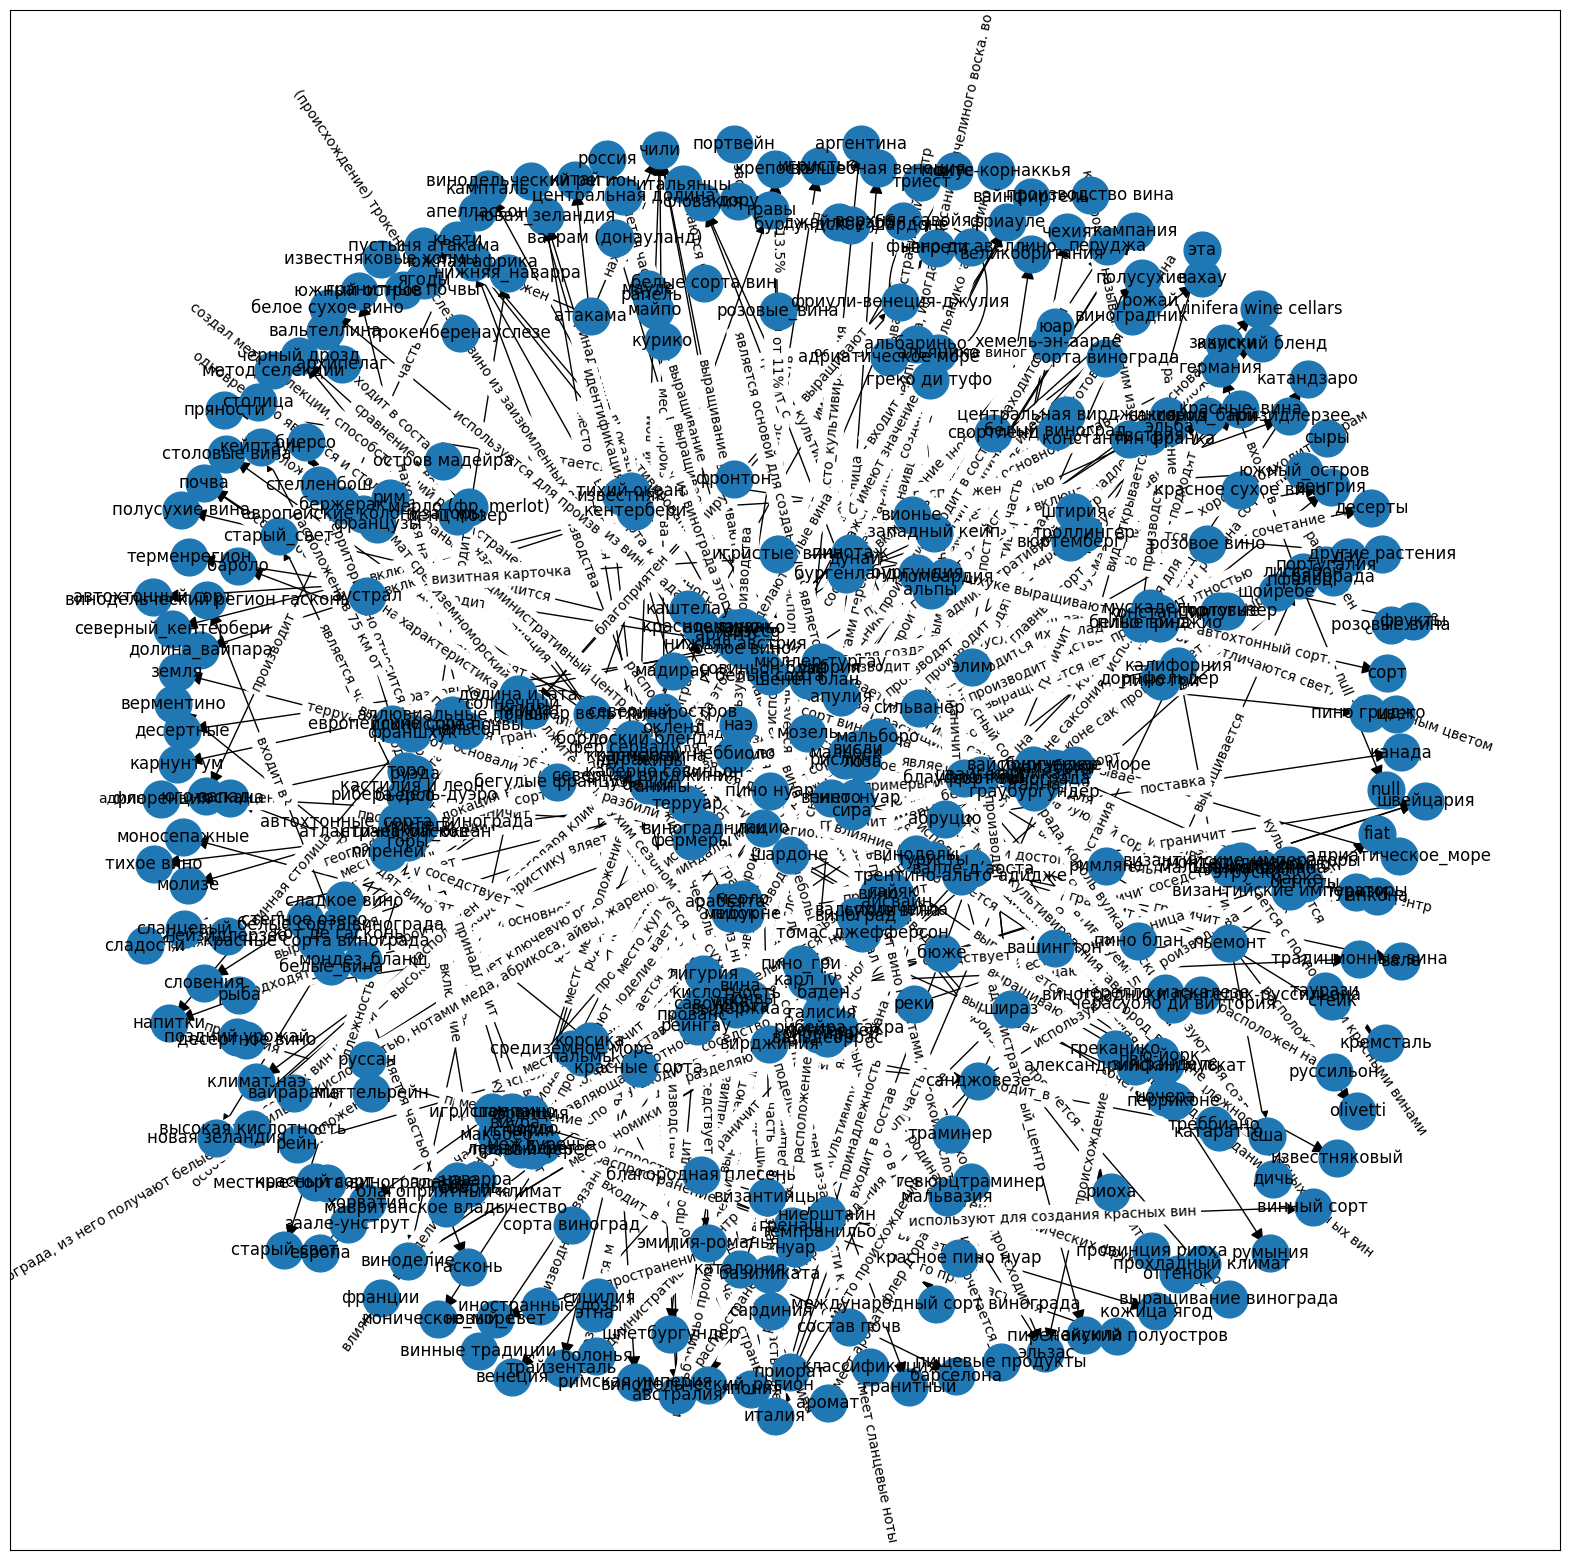

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

exist_entities = set([r['source'] for r in relations] + [r['target'] for r in relations])

for e,v in entities.items():
    if e in exist_entities:
        G.add_node(e, label=e)

for r in relations:
    G.add_edge(r['source'], r['target'], label=r['relation'], desc=r['desc'])

def plot_graph(G):
    plt.figure(figsize=(20,20))

    # Define node positions using a layout
    pos = nx.spring_layout(G)

    # Draw the nodes with labels
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'label'), font_size=12)

    # Draw the edges with labels
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='-|>', arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'label'))

    # Display the graph
    plt.show()

plot_graph(G)

Чтобы посмотреть внимательнее на граф, опишем функцию, которая извлекает подграф заданной глубины для заданной сущности:

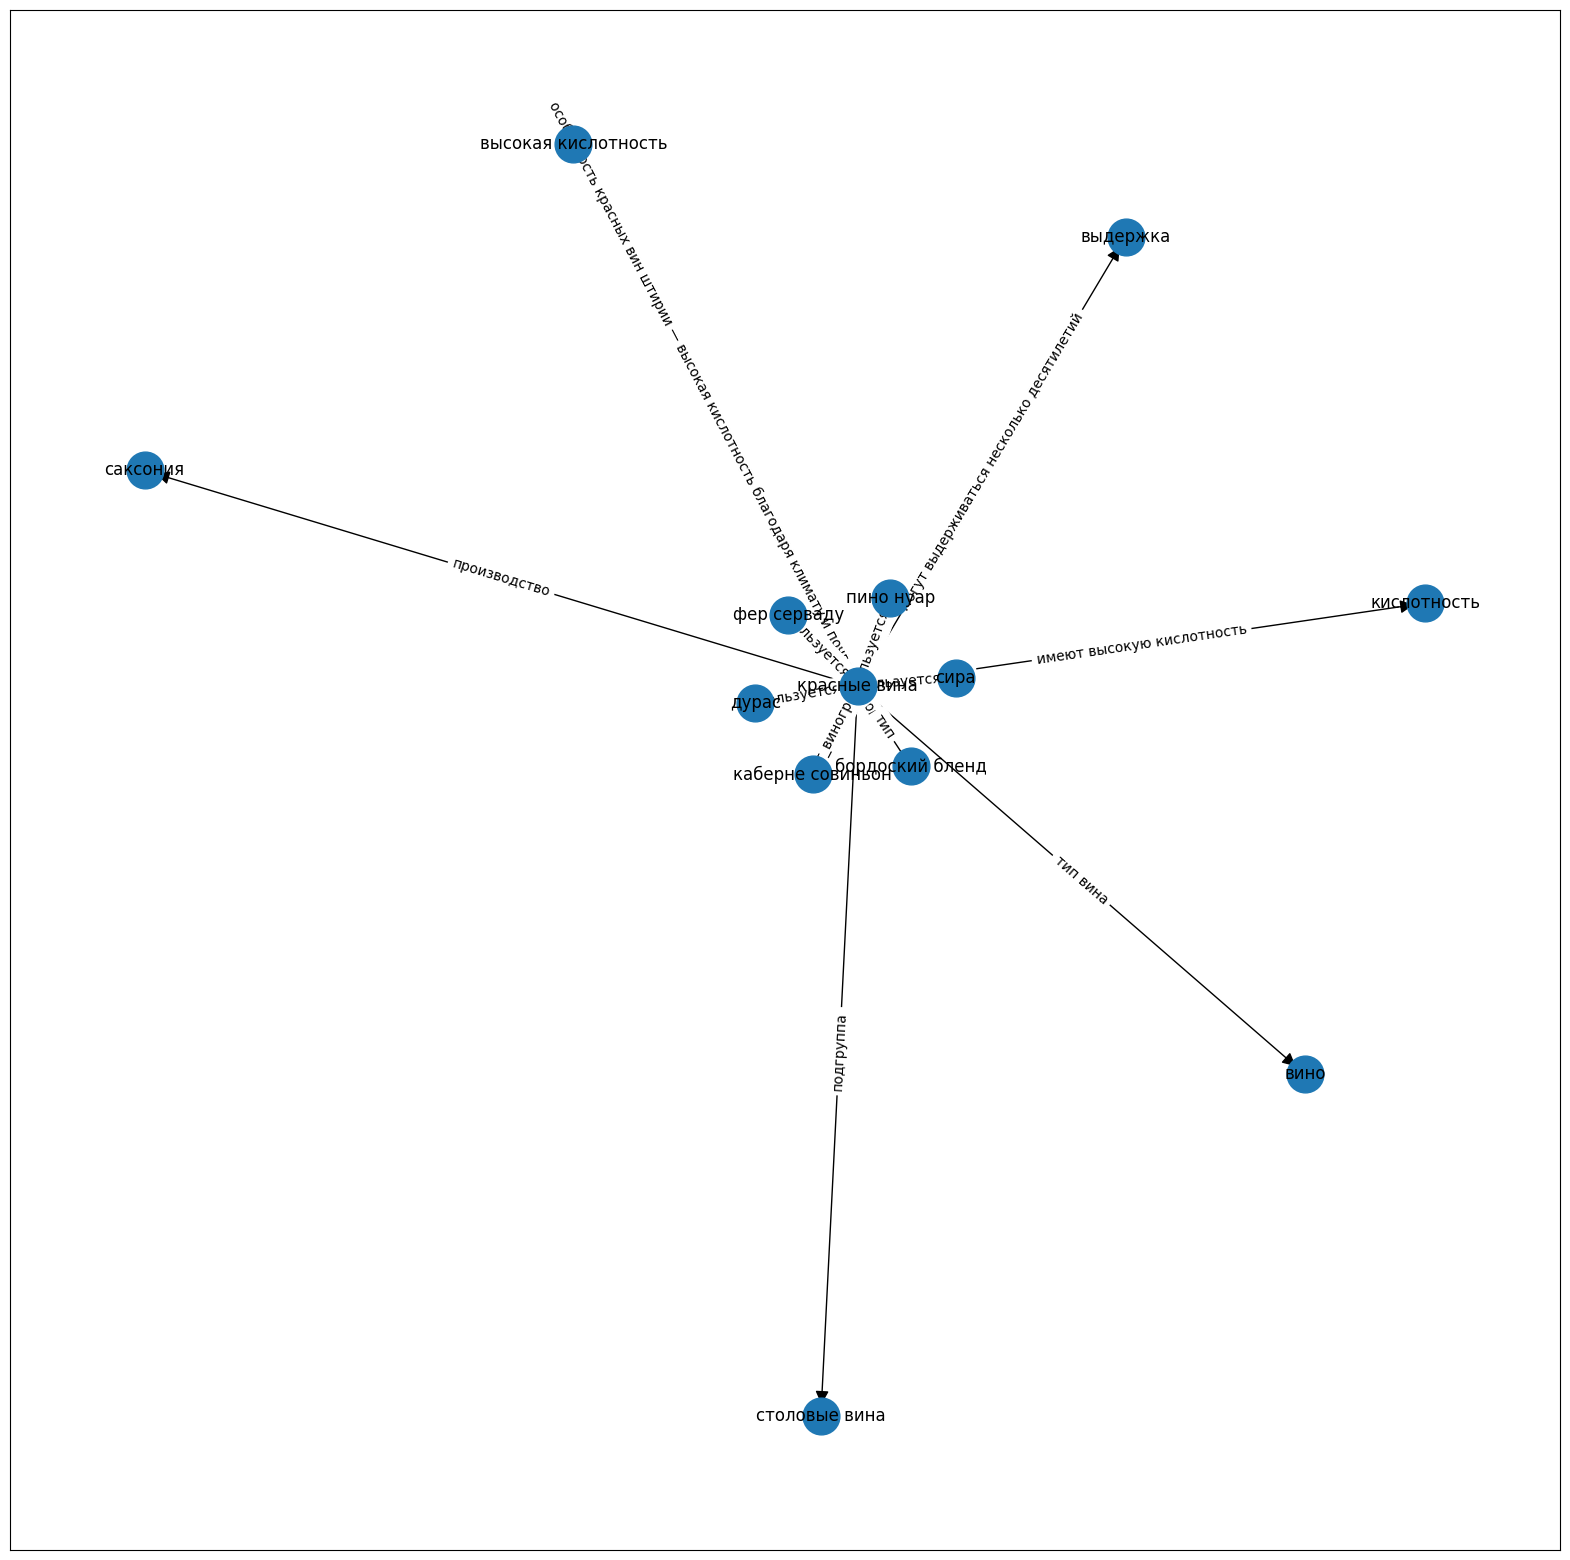

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

def populate_graph(G,e,level=None):
    if e in G.nodes:
        return
    if e in entities.keys():
        G.add_node(e, label=e)
    if level is not None and level<=0:
        return
    new_ent = set(
        [r['source'] for r in relations if r['target'] == e] + 
        [r['target'] for r in relations if r['source'] == e])
    for ne in new_ent:
        populate_graph(G,ne,None if level is None else level-1)
    for r in relations:
        if r['source'] == e:
            G.add_edge(e, r['target'], label=r['relation'], desc=r['desc'])
        if r['target'] == e:
            G.add_edge(r['source'], e, label=r['relation'], desc=r['desc'])
        
populate_graph(G,'красные вина',1)

plot_graph(G)

Теперь посмотрим, как организовать ответ на запросы пользователей. Для этого из запроса будем также извлекать все сущности:

In [9]:
entity_lookup_prompt = """
Ниже в тройных обратных кавычках приводится короткий текст. Тебе необходимо выделить из него все сущности,
похожие на сущности из списка в двойных кавычках: "{list}". Верни только список сущностей в скобках
через запятую, например: (Яндекс, компания, директор). Верни только те сущности, которые в явном виде
присутствуют в запросе. Не придумывай никакие дополнительные сущности и не рассуждай.
--текст--
```
{}
```
""".replace('{list}',', '.join(entities.keys()))

def process_q(txt):
    res = llm.invoke(entity_lookup_prompt.format(txt))
    if '(' in res and ')' in res:
        res = res[res.index('(')+1:res.index(')')]
        res = res.split(',')
        return [x.strip() for x in res]
    else:
        return None

q = "Расскажи поподробнее, что ты знаешь про сорт винограда сира?"
ents = process_q(q)
print(ents)

['сира']


Теперь используем обход сущностей-связей с ограничением глубины, чтобы извлечь всю релевантную информацию:

In [10]:
G = nx.DiGraph()
for e in ents:
    populate_graph(G,e,2)

for e in G.edges(data=True):
    print(e)

('сира', 'вашингтон', {'label': 'адаптируется', 'desc': 'сорт сира хорошо адаптируется к климату в вашингтоне'})
('сира', 'красные вина', {'label': 'используется для', 'desc': 'выращивают для производства красных вин'})
('сира', 'сорт винограда', {'label': 'является', 'desc': 'сорт сира является красным сортом винограда'})
('сира', 'окленд', {'label': 'произрастает', 'desc': 'сира произрастает в окленде'})
('вашингтон', 'сша', {'label': 'город_в_стране', 'desc': 'город вашингтон расположен в стране сша'})
('вашингтон', 'рислинг', {'label': 'используют', 'desc': 'вино из сорта рислинга делают в вашингтоне'})
('рислинг', 'сорт винограда', {'label': 'сорта винограда, растущие в аустрале', 'desc': 'в регионе аустрал выращивают виноград сорта рислинг'})
('красные вина', 'высокая кислотность', {'label': 'особенность красных вин штирии — высокая кислотность благодаря климату и почве региона', 'desc': ''})
('красные вина', 'саксония', {'label': 'производство', 'desc': 'красные вина производятс

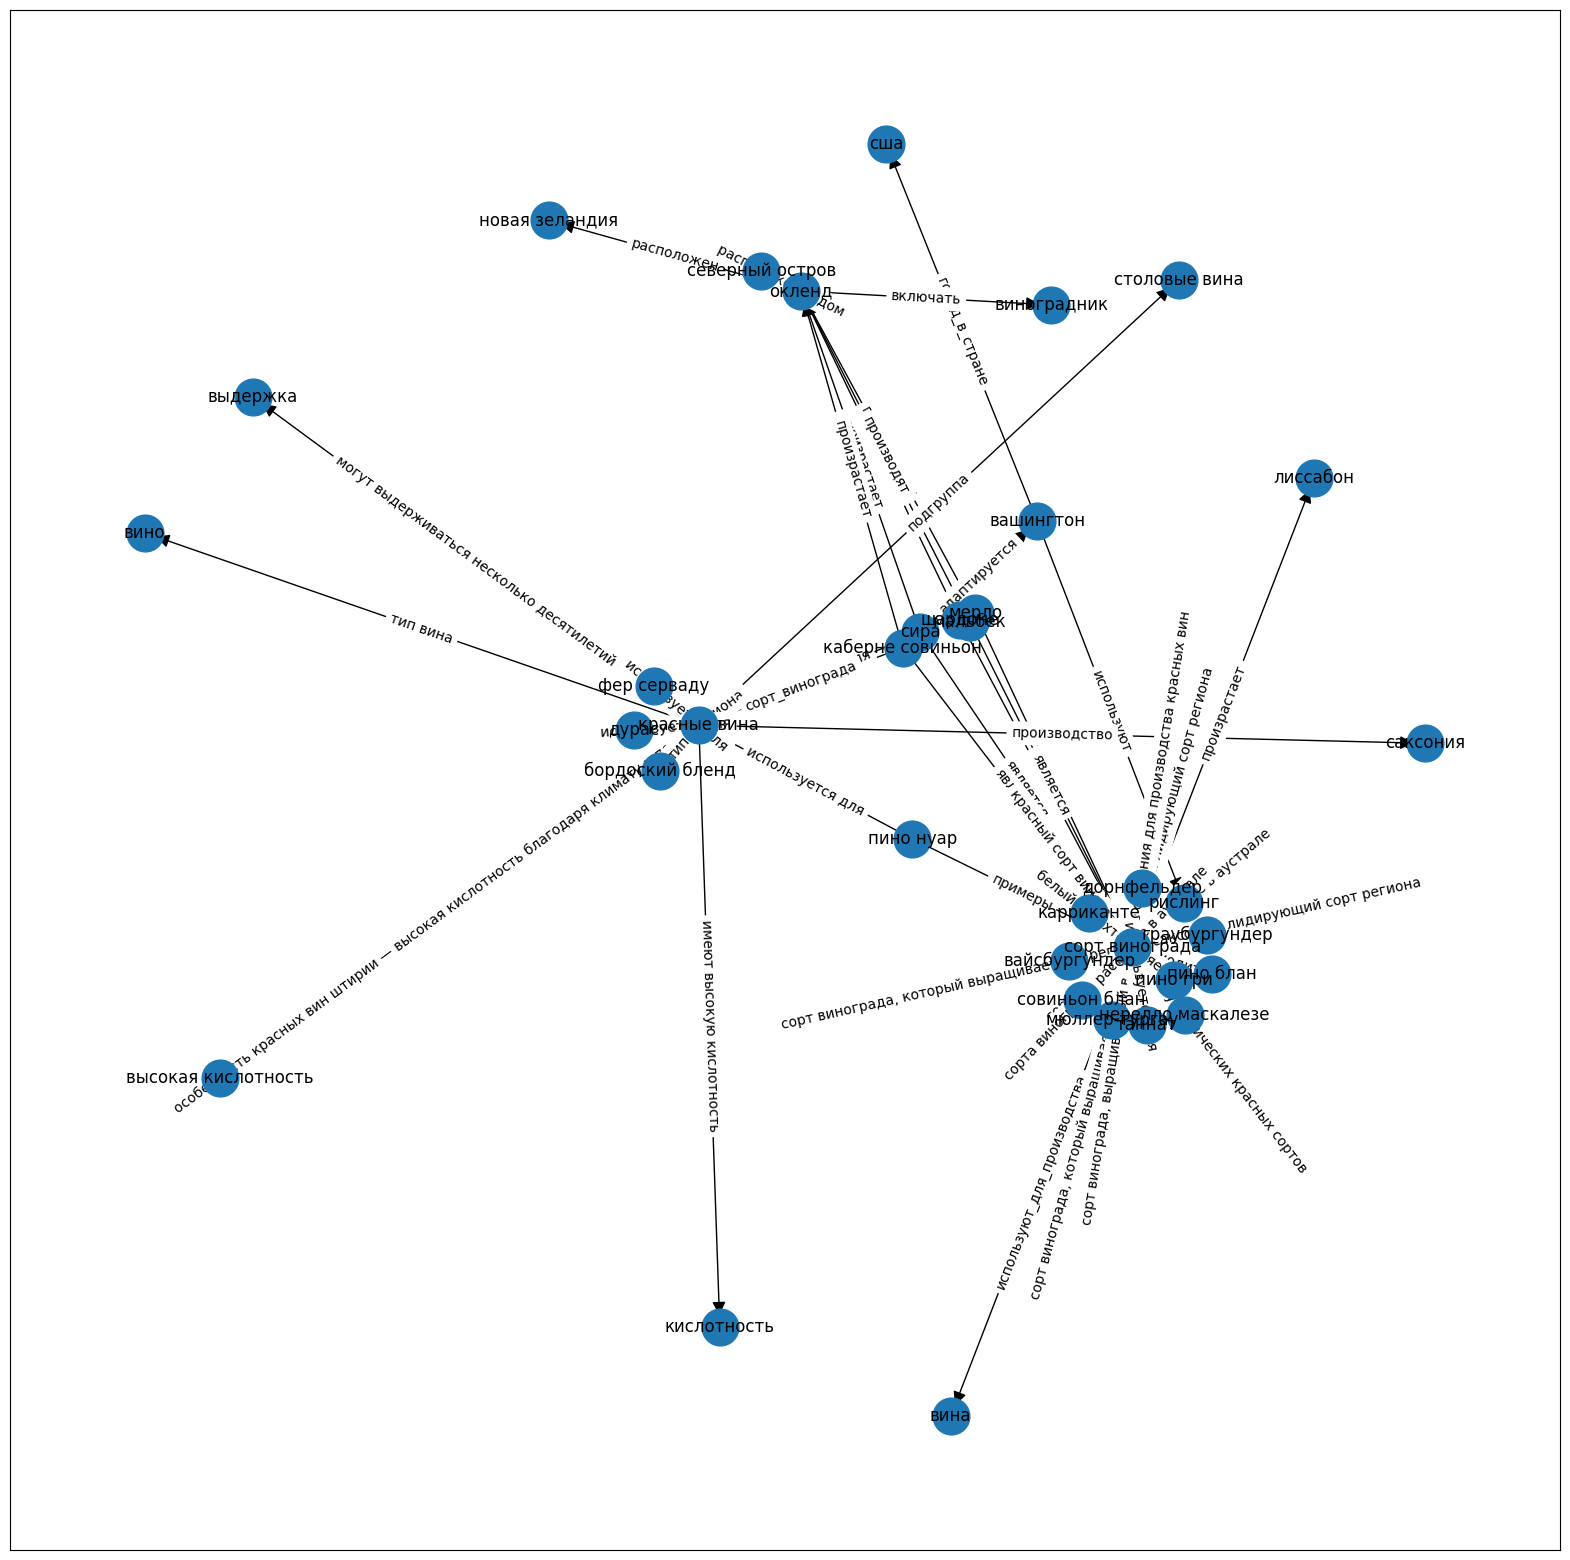

In [11]:
plot_graph(G)

Теперь попробуем сформировать ответ на вопрос пользователя с учётом этой информации:

In [12]:
answer_prompt = """
Тебе задан следующий запрос от пользователя: {question}.
Ответь на этот вопрос, используя при этом информацию, содержащуюся ниже в тройных обратных кавычках:
```
{context}
```
"""

def create_context(G):
    return '\n'.join(
        e[-1]['desc'] for e in G.edges(data=True))

ans = llm.invoke(answer_prompt
    .replace('{context}',create_context(G))
    .replace('{question}',q))
print(ans)

Сорт Сира — это красный сорт винограда, который хорошо адаптируется к климату Вашингтона. Его выращивают для производства красных вин.

Виноград сорта Сира произрастает в Окленде, городе, расположенном в США. Также его культивируют в регионе Аустрал. Красные вина из этого сорта отличаются насыщенным цветом и ароматом. Они прекрасно сочетаются с блюдами из мяса, например, со свининой или птицей.

Существует множество сортов красного винограда: Каберне Совиньон, Фер Серваду, Мерло, Мальбек, Пино Нуар, Сира и другие. Из них делают разные виды красных вин: бордоский бленд, кагор, красные столовые вина и др. Благодаря своему богатому вкусу и аромату, красные вина идеально подходят к мясным блюдам, а также к сырам и грибам.

К сожалению, в данном тексте содержится много противоречивой информации (например, вино из сорта рислинга производят в Вашингтоне, но в то же время в регионе Аустрал выращивают виноград сорта рислинг). Но можно сделать вывод, что сорт Сира широко используется в виноделии

## Извлечение сущностей нужного типа

Если внимательно посмотреть на извлечённые сущности, то становится видно, что иногда извлекаются сущности "странного" типа, и они засоряют граф знаний. Поэтому продуктивной кажется идея, когда мы в явном виде передаём список типов сущностей, которые надо извлекать. При этом мы слегка изменяем промпт: 

In [13]:
entity_extraction_prompt = """
# Цель
Тебе на вход даётся текстовый документ и список типов сущностей. Сначала выдели все сущности данного типа, которые присутствуют в тексте. Далее, найди все связи между этими сущностями. 

# Шаги
1. Выдели все сущности. Для каждой найденной сущности, укажи:
- entity_name: Имя сущности, заглавными буквами
- entity_type: Тип сущности, из следующего списка: {entity_types}. 
- entity_description: Подробное описание сущности.
Не используй кавычки, скобки и другие знаки препинания в имени сущности.
Выведи информацию о сущности в следующем виде (entity|<entity_name>|<entity_type>|<entity_description>), например: (entity|Яндекс|КОМПАНИЯ|Яндекс - это российская IT-компания)

2. Для всех сущностей, выделенных на шаге 1, выдели все связи, т.е. пары (исходная_сущность, целевая_сущность) которые "чётко связаны" между собой.
Для каждой пары связанных сущностей, извлеки следующую информацию:
- source_entity: имя исходной сущности, как она найдена на шаге 1
- target_entity: имя целевой сущности, как она найдена на шаге 1
- relationship_name: короткое имя связи между сущностями
- relationship_description: описание того, как исходная сущность и целевая сущность связаны между собой.
В связах могут участвовать только сущности, выделенные на шаге 1, имеющие один из типов {entity_types}. 
 Выведи информацию о связях в следующем виде (relationship|<source_entity>|<target_entity>|<relationship_name>|<relationship_description>), например: (relationship|Яндекс|Яндекс Такси|ВКЛЮЧАЕТ|Яндекс включает в себя сервис Яндекс Такси)

3. Выведи результат в виде списка, содержащего все сущности и связи, найденные на шагах 1 и 2. Используй **перевод строки** как разделитель списка. Не выводи ничего лишнего, только записи о сущностях и связях в скобках.

4. Когда закончишь, выведи [EOF]

-Реальные данные-
######################
Типы сущностей: {entity_types}
Текст: {text}
######################
Результат:
"""

entities = ['СОРТ ВИНОГРАДА','ТИП ВИНА','СТРАНА','РЕГИОН','БЛЮДО','ПРОДУКТ','ЕДА','АРОМАТ','ПРИПРАВА','ВЕЩЕСТВО','СВОЙСТВО ВИНА','ФРУКТ','ЯГОДА','ОБЛАСТЬ','ВОДОЕМ']
res = llm.invoke(entity_extraction_prompt.replace('{text}',normalize(text)).replace('{entity_types}',str(entities)))
print(res)

**Результат:**

(entity|Каберне фран|<СОРТ ВИНОГРАДА>|<Каберне фран — тёмный сорт винограда, один из древнейших мировых сортов, от которого произошли такие сорта как: каберне совиньон, карменер, мерло. Фран в названии обозначает французский.>)

(relationship|Каберне фран|Каберне совиньон|<СООТНОШЕНИЕ СОРТОВ ВИНОГРАДА>|От Каберне фран произошёл сорт Каберне Совиньон)

(relationship|Каберне фран|Карменер|<СООТНОШЕНИЕ СОРТОВ ВИНОГРАДА>|От Каберне фран произошёл сорт Карменер)

(relationship|Каберне фран|Мерло|<СООТНОШЕНИЕ СОРТОВ ВИНОГРАДА>|От Каберне фран произошёл сорт Мерло)

(relationship|Каберне фран|Красные вина|<ПРОИЗВОДСТВО ВИНА ИЗ СОРТА>|Из сорта Каберне Фран делают красные вина)

(relationship|Каберне фран|Розовые вина|<ПРОИЗВОДСТВО ВИНА ИЗ СОРТА>| Из сорта Каберне Фран получаются розовые вина)

(relationship|Красные вина|Моносортовые вина|<ВИДЫ ВИН>| Красные вина могут быть моносортовыми)

(relationship|Красные вина|Бленд|<ВИДЫ ВИН>|Красные вина часто используют для создания асс

Снова проходимся по всем текстам и извлекаем из них сущности заданных типов.

**ВНИМАНИЕ**: Этот код будет выполняться достаточно долго, и потребует ресурсов YandexGPT. Если вы смотрите код в режиме демонстрации - пропустите следующую ячейку.

In [34]:
from tqdm.auto import tqdm

with open('raw/er-typed.txt','w',encoding='utf-8') as f:
    for x in tqdm(wines):
        res = llm.invoke(entity_extraction_prompt.replace('{text}',normalize(x)).replace('{entity_types}',str(entities)))
        f.write(res)

In [35]:
with open('raw/er-reg-typed.txt','w',encoding='utf-8') as f:
    for x in tqdm(regions):
        res = llm.invoke(entity_extraction_prompt.replace('{text}',normalize(x)).replace('{entity_types}',str(entities)))
        f.write(res)

100%|██████████| 205/205 [58:59<00:00, 17.27s/it] 


Далее разбираем результаты:

In [14]:
with open('raw/er-typed.txt',encoding='utf-8') as f:
    lines = f.readlines()
with open('raw/er-reg-typed.txt',encoding='utf-8') as f:
    lines.extend(f.readlines())

entities, relations = extract_ER(lines)

print(f"Found {len(entities)} entities and {len(relations)} relations")

Invalid command: ['relation', 'сухой закон', '1920–1933', 'уничтожил', 'большую часть посадок уничтожили во время сухого закона']
Invalid command: ['relationhip', 'лоза', 'каберне-совиньон', 'является частью']
Invalid command: ['relation', 'аромат чернослива', 'аромат', '(relationship', 'аромат чернослива', 'аромат', 'аромат чернослива имеет место у вина из мальбека.)']
Invalid command: ['relation', 'аромат табака', 'аромат', '(relationship', 'аромат табака', 'аромат', 'табачный аромат имеется у вина из мальбека.)']
Invalid command: ['relation', 'аромат изюма', 'аромат', '(relationship', 'аромат изюма', 'аромат', 'изюмом пахнет вино из мальбека.)']
Invalid command: ['relation', 'слива', 'аромат', '(relationship', 'слива', 'аромат', 'сливовый вкус есть в шлейфе вина из мальбека.)']
Invalid command: ['relation', 'ежевика', 'аромат', '(relationship', 'ежевика', 'аротам', 'вину из сорта мальбек свойственен ежевичный привкус.)']
Invalid command: ['relation', 'гранат', 'аромат', '(relationsh

Записываем в файл для дальнейшего изучения:

In [16]:
with open('graphs/entities-typed.json','w',encoding='utf-8') as f:
    json.dump(entities,f,ensure_ascii=False,indent=4)
with open('graphs/relations-typed.json','w',encoding='utf-8') as f:
    json.dump(relations,f,ensure_ascii=False,indent=4)

Формируем и визуализируем граф:

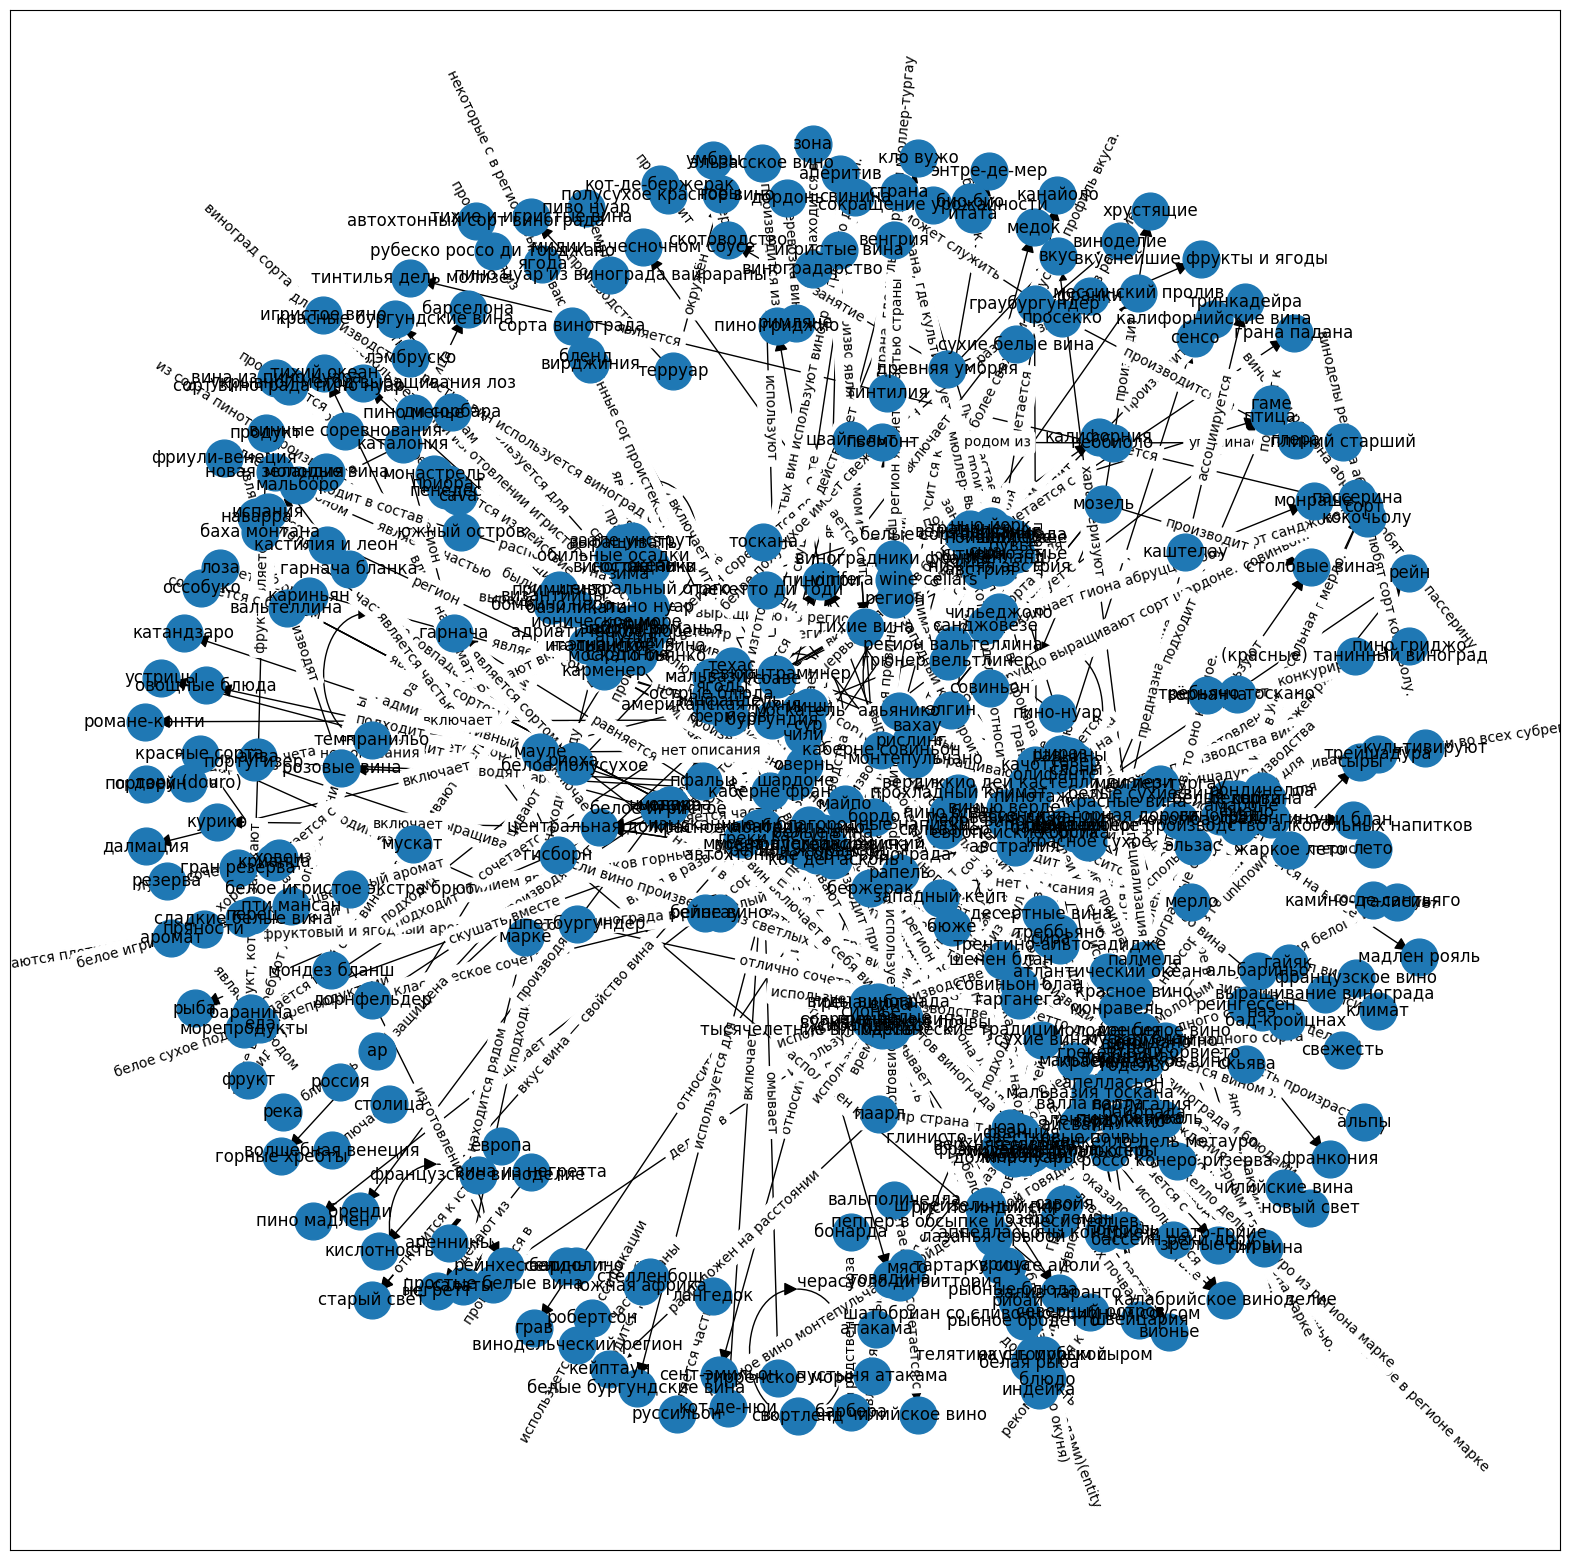

In [15]:
G = nx.DiGraph()

exist_entities = set([r['source'] for r in relations] + [r['target'] for r in relations])

for e,v in entities.items():
    if e in exist_entities:
        G.add_node(e, label=e)

for r in relations:
    G.add_edge(r['source'], r['target'], label=r['relation'])

plot_graph(G)

Обрабатываем запрос:

In [16]:
q = "Расскажи поподробнее, что ты знаешь про сорт винограда сира?"
ents = process_q(q)
print(ents)

['сира']


In [17]:
G = nx.DiGraph()
for e in ents:
    populate_graph(G,e,2)

ans = llm.invoke(answer_prompt
    .replace('{context}',create_context(G))
    .replace('{question}',q))
print(ans)

**Сира** (Syrah) — это сорт винограда, который происходит из Франции. Он относится к тёмным сортам винограда и используется для производства красных вин. Этот виноград имеет глубокий цвет и аромат с нотками чёрного перца, ежевики и табака.

**Сира известна под несколькими названиями**, например, во Франции её называют Шираз (Sirah), а в Италии — Серсоне (Sursace). 

Одним из наиболее известных регионов производства вина из этого сорта является долина Роны во Франции. Также этот сорт винограда выращивают в других странах Европы, таких как Италия, Испания, Швейцария, Германия и Австрия, а также в Новом Свете — Австралии, США и Южной Африке.

Сиру часто сравнивают с сортом **Шираз**, который культивируют в винодельческом регионе **Олифантс** в Австралии. Между этими двумя сортами есть заметные сходства: их отличает интенсивность цвета и пряный аромат. Но у каждого из них есть свои уникальные черты, благодаря которым вина различаются по вкусу и структуре.

Сира — сорт винограда с ярким хар

In [18]:
def answer(q,verbose=False,depth=2):
    ents = process_q(q)
    if verbose:
        print(f"Found entites: {ents}")
    if len(ents)<1:
        return ""
    G = nx.DiGraph()
    for e in ents:
        populate_graph(G,e.lower(),depth)
    if verbose:
        for e in G.edges(data=True):
            print(e)
    ans = llm.invoke(answer_prompt
    .replace('{context}',create_context(G))
    .replace('{question}',q))
    return ans

print(answer('Что лучше есть с шираз?',verbose=True))

Found entites: ['шираз']
('шираз', 'олифантс', {'label': 'культивируют', 'desc': 'виноград шираз культивируют в винодельческом регионе олифантс'})
('олифантс', 'юар', {'label': 'протекает через', 'desc': 'река олифантс протекает через юар'})
('олифантс', 'олифантс', {'label': 'является', 'desc': 'регион олифантс расположен в регионе олифантс'})
('олифантс', 'слоны', {'label': '', 'desc': ''})
('олифантс', 'совиньон блан', {'label': ',', 'desc': 'в регионе культивируют сорт совиньон блан'})
('олифантс', 'шенен блан', {'label': ',', 'desc': 'белые вина хороши с рыбой, морепродуктами, холодным мясом'})
('олифантс', 'каберне совиньон', {'label': ',', 'desc': 'каберне совиньон подают к блюдам из говядины и другим мясным закускам'})
('олифантс', 'шираз', {'label': ',', 'desc': 'к красному ширазу подают грибы, выдержанные сыры, сытные блюда из говядины'})
('олифантс', 'сенсо', {'label': ',', 'desc': 'виноград сенсо используют для производства красных вин'})
('север', 'олифантс', {'label': 'ра

In [86]:
print(answer('Где растёт шираз?',verbose=True))

Found entites: ['шираз']
('шираз', 'олифантс', {'label': 'культивируют', 'desc': 'виноград шираз культивируют в винодельческом регионе олифантс'})
('олифантс', 'юар', {'label': 'протекает через', 'desc': 'река олифантс протекает через юар'})
('олифантс', 'олифантс', {'label': 'является', 'desc': 'регион олифантс расположен в регионе олифантс'})
('олифантс', 'слоны', {'label': '', 'desc': ''})
('олифантс', 'совиньон блан', {'label': ',', 'desc': 'в регионе культивируют сорт совиньон блан'})
('олифантс', 'шенен блан', {'label': ',', 'desc': 'белые вина хороши с рыбой, морепродуктами, холодным мясом'})
('олифантс', 'каберне совиньон', {'label': ',', 'desc': 'каберне совиньон подают к блюдам из говядины и другим мясным закускам'})
('олифантс', 'шираз', {'label': ',', 'desc': 'к красному ширазу подают грибы, выдержанные сыры, сытные блюда из говядины'})
('олифантс', 'сенсо', {'label': ',', 'desc': 'виноград сенсо используют для производства красных вин'})
('совиньон блан', 'олифантс', {'lab

In [87]:
print(answer('Какие вина делают в регионе олифантс?',verbose=True))

Found entites: ['вина', 'регион олифантс']
('вина', 'блюдо', {'label': 'подаются с', 'desc': 'вина подаются с балыком, уткой, выпечкой и другими блюдами'})
('вина', 'виды винограда', {'label': 'вещество', 'desc': 'вино производят из определённых сортов винограда'})
('вина', 'рейнхессен', {'label': 'делают в', 'desc': 'в регионе рейнхессен делают вина'})
('вина', 'мозель', {'label': 'производят', 'desc': 'в мозеле производят вина'})
('овернь', 'сорта винограда', {'label': 'производит', 'desc': 'в оверни выращивают сорта винограда гаме, пино нуар и шардоне.'})
('овернь', 'вина', {'label': 'производит', 'desc': 'из сортов винограда, выращиваемых в оверни, производят вина кот-д’овернь и сен-пурсен.'})
('овернь', 'франция', {'label': 'входит', 'desc': 'регион овернь находится во франции.'})
('гренаш блан', 'вина', {'label': 'используется в производствe', 'desc': 'сорт гренаш блан используется в производстве вин'})
('сира (шираз)', 'вина', {'label': 'используется в производстве', 'desc': 'со

## Заключение

Мы с вами посмотрели на реализацию GraphRAG "с нуля". Существует несколько библиотек, которые поддерживают GraphRAG:

* Microsoft [GraphRAG](https://github.com/microsoft/graphrag)
* LangChain Experimental - [Graph Transformers](https://api.python.langchain.com/en/latest/experimental_api_reference.html#module-langchain_experimental.graph_transformers) [[статья](https://medium.com/data-science-in-your-pocket/graphrag-using-langchain-31b1ef8328b9)]
* [NeuML txtai](https://github.com/neuml/txtai) - [[статья](https://neuml.hashnode.dev/generate-knowledge-with-semantic-graphs-and-rag)]

К сожалению, интеграция YandexGPT и русского языка в эти библиотеки потребует существенных усилий, поскольку многие библиотеки завязаны на англоязычные большие LLM (GPT 4o), и часто содержат захардкоженные промпты. 

В целом для извлечения графов знаний необходима весьма мощная языковая модель.